---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/MyProject/RealFakeFaceImageClassification'

/content/drive/MyDrive/MyProject/RealFakeFaceImageClassification


In [4]:
!pwd

/content/drive/MyDrive/MyProject/RealFakeFaceImageClassification


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import shutil
import time

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data_dir = 'input'
batch_size = 32
num_epochs = 5
model_save_path = 'vit_model.pth'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [ ]:
num_total = len(dataset)
print(num_total)

2041


In [ ]:
num_train = int(0.8 * num_total)
num_val = num_total - num_train

In [ ]:
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

In [ ]:
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=2, ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = running_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

Epoch 1/5, Train Loss: 0.6935, Train Accuracy: 0.5497, Val Loss: 0.5341, Val Accuracy: 0.7677
Epoch 2/5, Train Loss: 0.4582, Train Accuracy: 0.8143, Val Loss: 0.3054, Val Accuracy: 0.9340
Epoch 3/5, Train Loss: 0.2542, Train Accuracy: 0.9280, Val Loss: 0.1234, Val Accuracy: 0.9780
Epoch 4/5, Train Loss: 0.0983, Train Accuracy: 0.9809, Val Loss: 0.0485, Val Accuracy: 0.9951
Epoch 5/5, Train Loss: 0.0397, Train Accuracy: 0.9966, Val Loss: 0.0183, Val Accuracy: 0.9951


In [ ]:
if os.path.exists('model'):
    shutil.rmtree('model')
    time.sleep(10)
    os.makedirs('model', exist_ok=True)
else:
    os.makedirs('model', exist_ok=True)
    time.sleep( )

In [ ]:
torch.save(model.state_dict(), os.path.join('model', model_save_path))
print("Model saved to", os.path.join('model', model_save_path))

Model saved to model/vit_model.pth


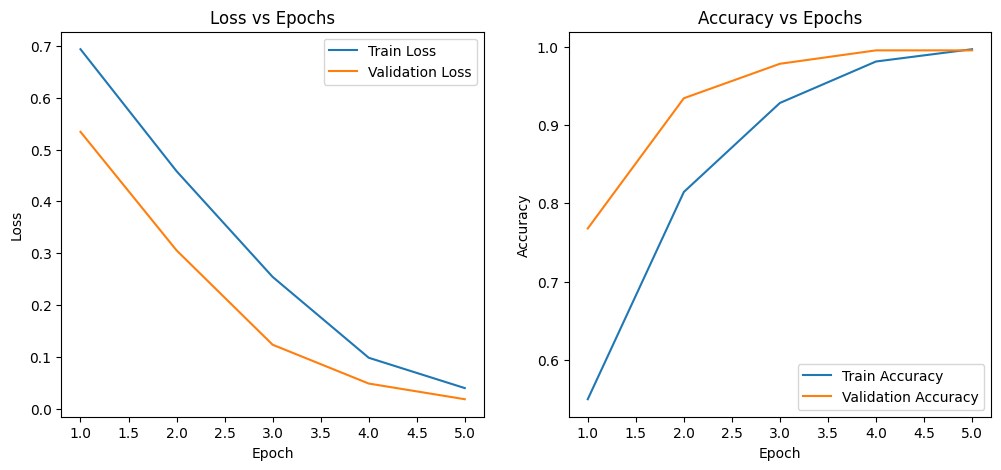

In [ ]:
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.show()

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs).logits
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

***Accuracy Score***

In [ ]:
class_labels = dataset.classes
print(class_labels)

['Fake', 'Real']


In [ ]:
model_accuracy = accuracy_score(y_true=all_labels, y_pred=all_preds)
print("Validation accuracy of ViT model is {:.2f}%".format(model_accuracy*100))

Validation accuracy of ViT model is 99.51%


***Classification Report***

In [ ]:
print(classification_report(y_true=all_labels, y_pred=all_preds, target_names=class_labels))

              precision    recall  f1-score   support

        Fake       1.00      0.99      0.99       197
        Real       0.99      1.00      1.00       212

    accuracy                           1.00       409
   macro avg       1.00      0.99      1.00       409
weighted avg       1.00      1.00      1.00       409



***Confusion Matrix***

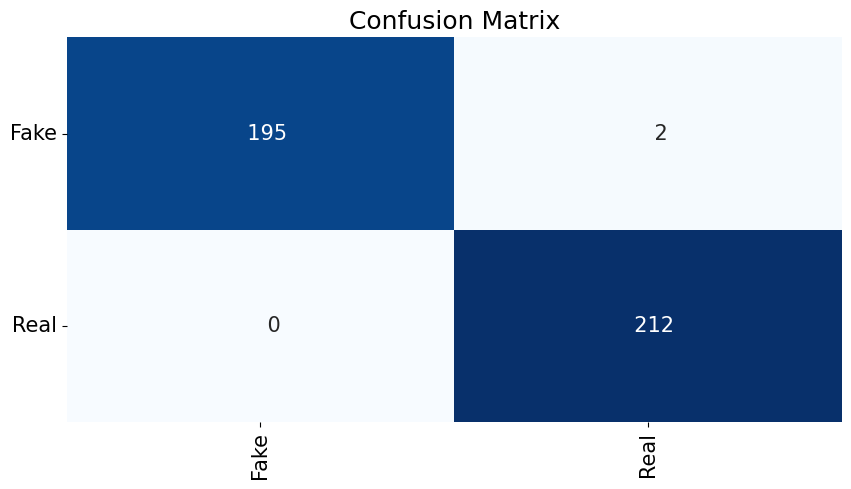

In [ ]:
plt.figure(figsize=(10,5))
plt.rcParams['font.size'] = 15
sns.heatmap(data=confusion_matrix(y_true=all_labels, y_pred=all_preds),
            annot=True,
            cmap=plt.cm.Blues,
            fmt = "5d",
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar=False)
plt.title(label="Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()